In [38]:
import cv2 
import os
import imghdr
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
import pickle
import json

In [39]:
parentDir=os.getcwd()
dataDir=os.path.join(parentDir,"Dataset")
imgDimension=[]

for idx,folder in enumerate(os.listdir(dataDir)):
    dataChild=os.path.join(dataDir,folder)
    for file in os.listdir(dataChild):
        filePath=os.path.join(dataChild,file)

        img=cv2.imread(filePath)
        
        if img.shape not in imgDimension:
            imgDimension.append(img.shape)

imgHeight,imgWidth,channels=imgDimension[0]

In [40]:
for folder in os.listdir(dataDir):
    dataChild=os.path.join(dataDir,folder)

    for file in os.listdir(dataChild):
        fname,ext=os.path.splitext(file)
        filePath=os.path.join(dataChild,file)
        
        try:
            img=cv2.imread(filePath)
            
        except Exception as e:
            print(e)
            os.remove(filePath)
        
        if ext.lower() not in [".jpeg",".png",".jpg"]:
            os.remove(filePath)


In [41]:
data=tf.keras.utils.image_dataset_from_directory("Dataset")
class_names = data.class_names
class_dict={}

for idx,cls in enumerate(class_names):
    class_dict[idx]=cls
    
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()

batch

#-----Image------
images=batch[0]

#-----Labels-----
labels=batch[1]

Found 12045 files belonging to 2 classes.


In [42]:
data_iterator

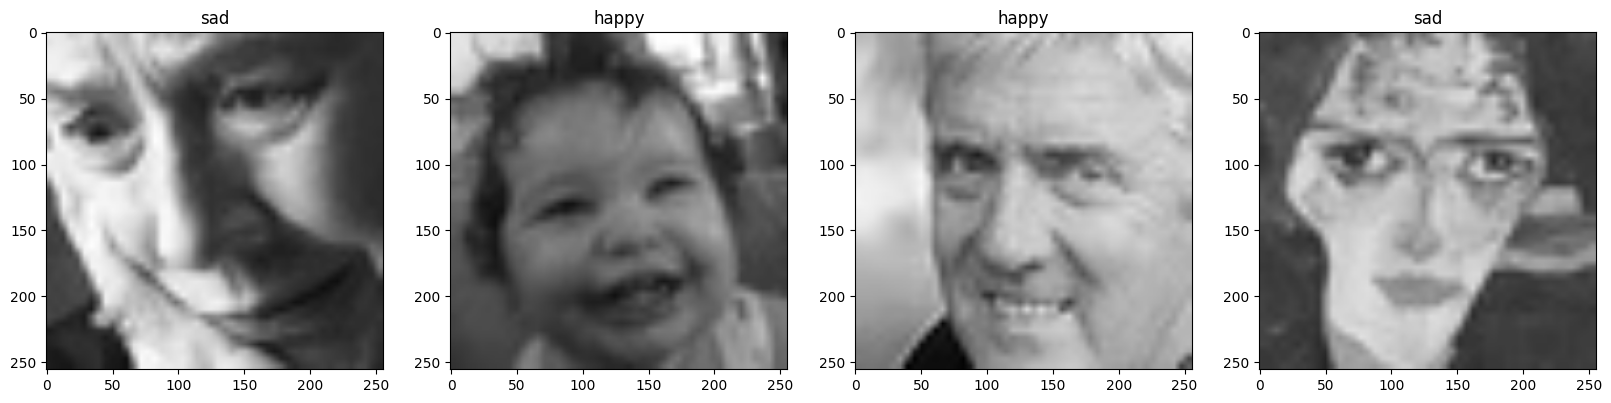

In [43]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))

for idx, img in enumerate(images[:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_dict[labels[idx]])
    

In [44]:
# plt.subplot??

In [45]:
batch[0].shape

(32, 256, 256, 3)

In [46]:
# Preprocessing Data

In [47]:
data=data.map(lambda x,y:(x/255,y))

In [48]:
print(len(data))

377


In [49]:
train_size=int(len(data)*0.7)
test_size=int(len(data)*0.1)
val_size=int(len(data)*0.2)

In [50]:
print(train_size+test_size+val_size)

375


In [51]:
print(len(data))

377


In [52]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [53]:
model=models.Sequential([
    layers.Conv2D(16,(3,3),activation="relu",input_shape=(256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation="relu",input_shape=(256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=(256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256,activation="relu"),
    layers.Dense(1,activation="sigmoid")
])

In [54]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)       

In [56]:
logDir="logs"
os.makedirs(logDir,exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logDir)
history=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
263/263 [==============================] - 144s 533ms/step - loss: 0.6633 - accuracy: 0.6153 - val_loss: 0.6319 - val_accuracy: 0.6496
Epoch 2/20
263/263 [==============================] - 124s 469ms/step - loss: 0.5848 - accuracy: 0.6890 - val_loss: 0.5508 - val_accuracy: 0.7167
Epoch 3/20
263/263 [==============================] - 137s 520ms/step - loss: 0.5166 - accuracy: 0.7452 - val_loss: 0.5316 - val_accuracy: 0.7275
Epoch 4/20
263/263 [==============================] - 137s 519ms/step - loss: 0.4551 - accuracy: 0.7820 - val_loss: 0.5118 - val_accuracy: 0.7437
Epoch 5/20
263/263 [==============================] - 2382s 9s/step - loss: 0.3775 - accuracy: 0.8256 - val_loss: 0.5172 - val_accuracy: 0.7400
Epoch 6/20
263/263 [==============================] - 234s 890ms/step - loss: 0.2961 - accuracy: 0.8705 - val_loss: 0.5467 - val_accuracy: 0.7596
Epoch 7/20
263/263 [==============================] - 184s 699ms/step - loss: 0.2001 - accuracy: 0.9146 - val_loss: 0.6288 - v

In [57]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]


In [58]:
print(history)

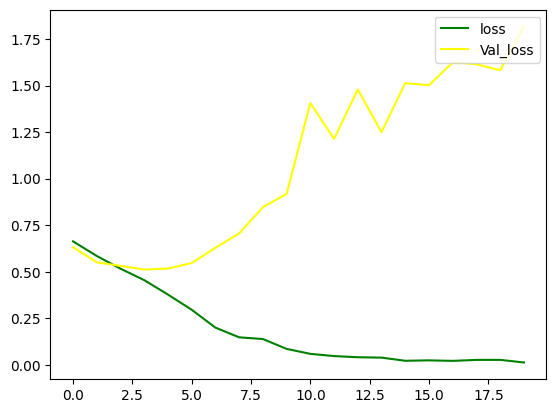

In [59]:
plt.plot(loss,color="green",label="loss")
plt.plot(val_loss,color="yellow",label="Val_loss")
plt.legend(loc="upper right")
plt.show()

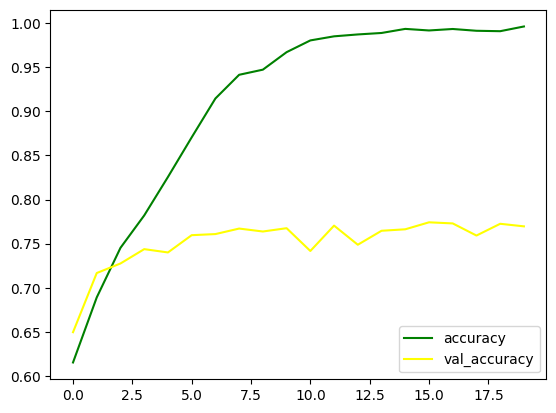

In [60]:
plt.plot(accuracy,color="green",label="accuracy")
plt.plot(val_accuracy,color="yellow",label="val_accuracy")
plt.legend(loc="lower right")
plt.show()

In [61]:
# H5 is a serialization data format
model.save("image_classifier_model.h5")

C:\myenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
import pickle
with open("model.pkl","wb") as f:
    pickle.dump(model,f)